In [2]:
# Generic
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, re, warnings
import requests
from pprint import pprint

warnings.filterwarnings("ignore")

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Loading Universal Sentence Encoder

import tensorflow as tf
import tensorflow_hub as hub

encoder = hub.load("./model")

In [29]:
# Custom Function to Estimate & then plot(heatmap) the text similarity


def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        robust=True,
        cbar=False,
        square=True,
        annot=True,
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Similarity", fontsize=25)


def run_and_plot(messages_):
    message_embeddings_ = encoder(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

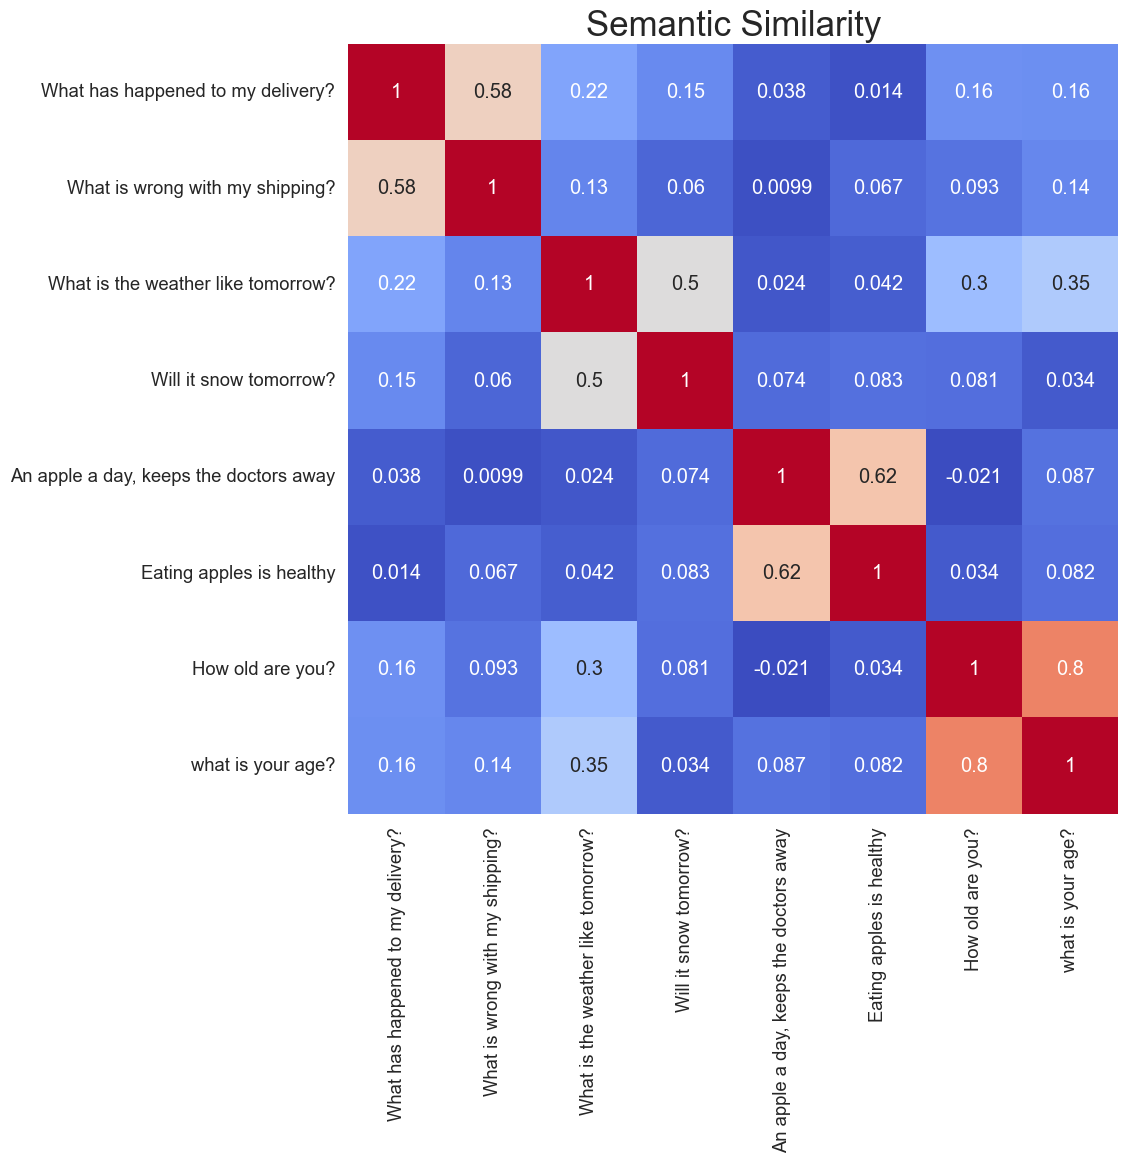

In [30]:
messages = [
    # Shipping
    "What has happened to my delivery?",
    "What is wrong with my shipping?",
    # Weather
    "What is the weather like tomorrow?",
    "Will it snow tomorrow?",
    # Health
    "An apple a day, keeps the doctors away",
    "Eating apples is healthy",
    # Age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

In [7]:
def simularity(word1, word2):
    features = encoder([word1, word2])
    inner = np.inner(features, features)
    return inner[1][0]


In [8]:
simularity("tv, sound, image", "Sound and image")


0.5630873

In [9]:
simularity("Headphones accessories", "Headphones")


0.8231752

In [10]:
from google.cloud import translate

client = translate.TranslationServiceClient()
location = "global"
parent = f"projects/prisfinder/locations/{location}"  # project id 789995683879


def translate_to_eng(text: str):
    response = client.translate_text(
        request={
            "parent": parent,
            "contents": [text],
            "mime_type": "text/plain",
            "source_language_code": "nb-NO",
            "target_language_code": "en",
        }
    )

    return response.translations[0].translated_text


print(translate_to_eng("true-wireless-hodetelefoner"))
print(translate_to_eng("oerepropper"))

true wireless headphones
earplugs


In [97]:
# Download finn categories


def download_finn_categories():
    url = (
        "https://www.finn.no/api/search-qf?searchkey=SEARCH_ID_BAP_COMMON&vertical=bap"
    )

    response = requests.get(url)
    data = response.json()
    filters = data["filters"]

    categories = next(x for x in filters if x["name"] == "category")

    def gen(filter_items, parent=None):
        for filter_item in filter_items:
            value = filter_item["value"]
            value_end = value.split(".")[-1]
            name = filter_item["display_name"]
            yield {
                "name": name,
                "name_eng": translate_to_eng(name),
                "id": value_end,
                "depth": value.split(".")[0],
                "parent": parent,
            }

            yield from gen(filter_item["filter_items"], parent=value_end)

    return [*gen(categories["filter_items"])]


found_categories = download_finn_categories()

pprint(found_categories)

[{'depth': '0',
  'id': '76',
  'name': 'Antikviteter og kunst',
  'name_eng': 'Antiquities and art',
  'parent': None},
 {'depth': '1',
  'id': '5175',
  'name': 'Andre antikviteter',
  'name_eng': 'Other antiques',
  'parent': '76'},
 {'depth': '1',
  'id': '5178',
  'name': 'Antikke møbler',
  'name_eng': 'Antique furniture',
  'parent': '76'},
 {'depth': '1',
  'id': '5176',
  'name': 'Keramikk, porselen og glass',
  'name_eng': 'Ceramics, porcelain and glass',
  'parent': '76'},
 {'depth': '1',
  'id': '5177',
  'name': 'Kunst',
  'name_eng': 'Art',
  'parent': '76'},
 {'depth': '2',
  'id': '385',
  'name': 'Akryl',
  'name_eng': 'Acrylic',
  'parent': '5177'},
 {'depth': '2',
  'id': '386',
  'name': 'Akvarell',
  'name_eng': 'Watercolor',
  'parent': '5177'},
 {'depth': '2',
  'id': '395',
  'name': 'Annen kunst',
  'name_eng': 'Other art',
  'parent': '5177'},
 {'depth': '2',
  'id': '387',
  'name': 'Blandingsteknikker',
  'name_eng': 'Mixing techniques',
  'parent': '5177'},

In [101]:
import json


def save_json(obj, filename):
    with open(filename, "w") as f:
        json.dump(obj, f, indent=4)


save_json(found_categories, "finn_categories.json")

In [12]:
import json

def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

finn_categories = load_json("finn_categories.json")

In [14]:
def sort_categories(categories):
    main = [c for c in categories if c["depth"] == "0"]
    sub = [c for c in categories if c["depth"] == "1"]
    product = [c for c in categories if c["depth"] == "2"]
    return main, sub, product


main_categories, sub_categories, product_categories = sort_categories(finn_categories)

pprint(product_categories)

[{'depth': '2',
  'id': '385',
  'name': 'Akryl',
  'name_eng': 'Acrylic',
  'parent': '5177'},
 {'depth': '2',
  'id': '386',
  'name': 'Akvarell',
  'name_eng': 'Watercolor',
  'parent': '5177'},
 {'depth': '2',
  'id': '395',
  'name': 'Annen kunst',
  'name_eng': 'Other art',
  'parent': '5177'},
 {'depth': '2',
  'id': '387',
  'name': 'Blandingsteknikker',
  'name_eng': 'Mixing techniques',
  'parent': '5177'},
 {'depth': '2',
  'id': '388',
  'name': 'Fotografi',
  'name_eng': 'Photograph',
  'parent': '5177'},
 {'depth': '2',
  'id': '389',
  'name': 'Litografi',
  'name_eng': 'Lithography',
  'parent': '5177'},
 {'depth': '2',
  'id': '390',
  'name': 'Oljemaleri',
  'name_eng': 'Oil painting',
  'parent': '5177'},
 {'depth': '2',
  'id': '391',
  'name': 'Skulptur',
  'name_eng': 'Sculpture',
  'parent': '5177'},
 {'depth': '2',
  'id': '392',
  'name': 'Tegning',
  'name_eng': 'Drawing',
  'parent': '5177'},
 {'depth': '2',
  'id': '393',
  'name': 'Tresnitt',
  'name_eng': 

In [112]:
def category_candidates(category: str):
    category_eng = translate_to_eng(category)
    return [
        (simularity(category_eng, p["name_eng"]), p)
        for p in product_categories
        if simularity(category_eng, p["name_eng"]) > 0.5
    ]


pprint(category_candidates("oerepropper"))
print()
# pprint(category_candidates("Hodetelefoner"))
print()
pprint(category_candidates("true-wireless-hodetelefoner"))
print()
pprint(category_candidates("headsets"))

[(0.58270264,
  {'depth': '2',
   'id': '51',
   'name': 'Hodetelefoner',
   'name_eng': 'Headphones',
   'parent': '3906'})]


[(0.59127533,
  {'depth': '2',
   'id': '51',
   'name': 'Hodetelefoner',
   'name_eng': 'Headphones',
   'parent': '3906'})]

[(0.73707205,
  {'depth': '2',
   'id': '51',
   'name': 'Hodetelefoner',
   'name_eng': 'Headphones',
   'parent': '3906'}),
 (0.50662947,
  {'depth': '2',
   'id': '53',
   'name': 'Høyttalere',
   'name_eng': 'Speakers',
   'parent': '3906'}),
 (0.51122034,
  {'depth': '2',
   'id': '39',
   'name': 'Mobiltelefoner',
   'name_eng': 'Mobile phones',
   'parent': '3217'}),
 (0.50918305,
  {'depth': '2',
   'id': '108',
   'name': 'Lydutstyr',
   'name_eng': 'Audio equipment',
   'parent': '92'})]


In [15]:
test_categories = ["tv-lyd-bilde", "hodetelefoner-tilbehoer", "oerepropper"]
translated_categories = [translate_to_eng(c) for c in test_categories]
print(translated_categories)


['TV sound image', 'headphone accessories', 'earplugs']


In [18]:
def get_finn_category_parent(category: dict) -> dict:
    if category["parent"] is None: return None
    return next(c for c in finn_categories if c["id"] == category["parent"])

def get_finn_category_parents(category: dict) -> list[dict]:
    parent = get_finn_category_parent(category)
    if not parent:
        return []
    
    return [parent, *get_finn_category_parents(parent) ]


get_finn_category_parents(
    {
        "name": "Hodetelefoner",
        "name_eng": "Headphones",
        "id": "51",
        "depth": "2",
        "parent": "3906",
    }
)

[{'name': 'Lyd og bilde',
  'name_eng': 'Sound and image',
  'id': '3906',
  'depth': '1',
  'parent': '93'},
 {'name': 'Elektronikk og hvitevarer',
  'name_eng': 'Electronics and appliances',
  'id': '93',
  'depth': '0',
  'parent': None}]

In [42]:
import itertools


def parse_categories(categories: list[str]):
    l = 0
    found_categories = []
    while l < len(categories) and len(found_categories) < 10:
        l += 1
        scores = []
        for finn_category in [*product_categories, *sub_categories]:
            name_eng = finn_category["name_eng"]
            score = simularity(name_eng, categories[-l])
            scores.append((score, finn_category))

        scores.sort(key=lambda s: s[0], reverse=True)

        found_categories.extend([cat for s, cat in scores[:10] if s > 0.3])

    scores = []

    for finn_category in found_categories:
        parents = get_finn_category_parents(finn_category)
        finn_category_names = [finn_category, *parents]
        finn_category_names = [c["name_eng"] for c in finn_category_names]

        product = itertools.product(finn_category_names, categories)
        score = max(simularity(a, b) for a, b in product)
        scores.append((score, finn_category))

    scores.sort(key=lambda s: s[0], reverse=True)

    _, finn_category = scores[0]

    parents = get_finn_category_parents(finn_category)
    category_and_parents = [finn_category, *parents][::-1]
    finn_category_ids = [c["id"] for c in category_and_parents]
    names = [c["name"] for c in category_and_parents]

    n = len(category_and_parents)

    prefix = ["category", "sub_category", "product_category"][n-1]
    code = f"{prefix}={n-1}.{'.'.join(finn_category_ids)}"

    return code, names


print(parse_categories(translated_categories))
print(parse_categories(["tv and video", "CANNON cameras"]))
print(parse_categories(["Activities and art", "Antique furniture"]))
print(parse_categories(["hardware", "phones and gps", "smartphone accessories", "headsets"]))

('product_category=2.93.3906.51', ['Elektronikk og hvitevarer', 'Lyd og bilde', 'Hodetelefoner'])
('product_category=2.93.3904.504', ['Elektronikk og hvitevarer', 'Foto og video', 'Videokameraer'])
('sub_category=1.76.5178', ['Antikviteter og kunst', 'Antikke møbler'])
('product_category=2.93.3906.51', ['Elektronikk og hvitevarer', 'Lyd og bilde', 'Hodetelefoner'])


In [44]:
depth_scores = {
    0: 0.5,
    1: 1.0,
    2: 2.0,
}

def find_score(category_list: list[str], finn_category: dict):
    i_multipliers = {
        0: 10,
        1: 3,
        2: 1,
    }    

    j_multipliers = {
        0: 5,
        1: 2,
        2: 2,
    }

    parents = get_finn_category_parents(finn_category)
    finn_category_list = [*parents[::-1], finn_category]

    score = 0
    for i, category_list_name in enumerate(category_list[::-1]):
        for j, finn_category_list_name in enumerate(finn_category_list[::-1]):
            current = simularity(category_list_name, finn_category_list_name["name_eng"])
            current *= i_multipliers.get(i, 1)
            current *= j_multipliers.get(j, 1)
            score += current
    
    return score

def find_simular_category(category_list: list[str]) -> dict:
    best_score = -1
    current_result = None

    for category in finn_categories:
        depth = int(category["depth"])
        score = find_score(category_list, category) * depth_scores[depth]

        if score > best_score:
            best_score = score
            current_result = category
    
    return current_result, best_score

print(find_simular_category(["hardware", "phones and gps", "smartphone accessories", "headsets"]))
print(find_simular_category(["tv and video", "CANNON cameras"]))
print(find_simular_category(["Activities and art", "Antique furniture"]))
print(find_simular_category(translated_categories))

({'name': 'Hodetelefoner', 'name_eng': 'Headphones', 'id': '51', 'depth': '2', 'parent': '3906'}, 124.9007078409195)
({'name': 'Videokameraer', 'name_eng': 'Video cameras', 'id': '504', 'depth': '2', 'parent': '3904'}, 119.40600973367691)
({'name': 'TV-møbler', 'name_eng': 'TV furniture', 'id': '224', 'depth': '2', 'parent': '8345'}, 98.43382042646408)
({'name': 'Hodetelefoner', 'name_eng': 'Headphones', 'id': '51', 'depth': '2', 'parent': '3906'}, 107.04406434297562)


In [1]:
# TODO: find most fitting finn category name for each name first

def most_fitting_finn_category(name: str, predicted_depth: int) -> dict:
    best_score = 0
    best_finn_category = None
    for finn_category in finn_categories:
        parents = get_finn_category_parents(finn_category)
        actual_depth = len(parents)

        finn_name = finn_category["name_eng"]
        score = simularity(name, finn_name) / (1.4 ** abs(actual_depth - predicted_depth))

        if score > best_score:
            best_score = score
            best_finn_category = finn_category

    return best_finn_category

def category_list_to_finn_category(category_list: list[str]) -> dict:
    def candidates():
        for i, name in enumerate(category_list):
            predicted_depth = i * 2 / (len(category_list) - 1)
            yield most_fitting_finn_category(name, predicted_depth)

    best_score = 0
    best_candidate = None

    for i, candidate in enumerate(candidates()):
        predicted_depth = i * 2 / (len(category_list) - 1)
        actual_depth = int(candidate["depth"])

        score = simularity(candidate["name_eng"], category_list[i])
        score *= 2 * (actual_depth + 1)
        score /= 1.2 ** abs(predicted_depth - actual_depth)

        if score > best_score:
            best_score = score
            best_candidate = candidate

    return best_candidate

def format_finn_category(finn_category):
    parents = get_finn_category_parents(finn_category)
    full_category = [*parents[::-1], finn_category]
    full_category_name = "/".join(c["name_eng"] for c in full_category)
    return full_category_name

category_lists = [
    ["hardware", "phones and gps", "smartphone accessories", "headsets"],
    ["tv and video", "CANNON cameras"],
    ["Activities and art", "Antique furniture"],
    translated_categories,
]

for category_list in category_lists:
    finn_category = category_list_to_finn_category(category_list)
    formatted = format_finn_category(finn_category)
    print(f'"{"/".join(category_list)}" --> "{formatted}"')

NameError: name 'translated_categories' is not defined

: 

In [ ]:
# TODO: write tests to determine the effectiveness of this function